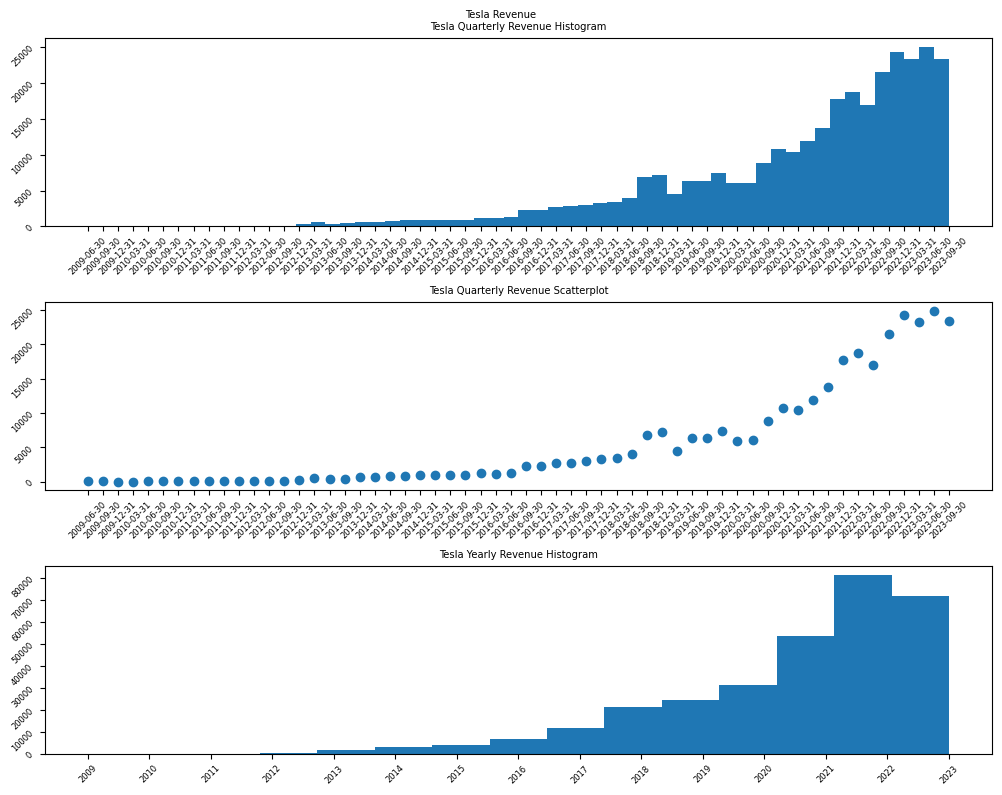

In [33]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import sqlite3
import requests
import matplotlib.pyplot as plt
import string

def cleanValue(value):
    if value == "":
        return 0
    return int(value.replace("$","").replace(",",""))

# Step 2
URL = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
headers={'User-Agent': 'Mozilla/5.0'}

html_string = requests.get(URL, headers=headers)

soup = bs(html_string.content.decode())

# Step 3
tables = soup.find_all("table")

rows = tables[1].find("tbody").find_all("tr")

data = [[col.get_text(strip=True) for col in tr.find_all('td')] for tr in rows]

# Step 4
quarterly_report = pd.DataFrame(data, columns=["quarter", "value"])
quarterly_report["value"] = quarterly_report["value"].apply(lambda x: cleanValue(x))
quarterly_report = quarterly_report.reindex(index=quarterly_report.index[::-1])

# Create yearly report
yearly_report = pd.DataFrame({
    'year': quarterly_report['quarter'], 
    'value': quarterly_report['value']
    })
yearly_report['year'] = yearly_report['year'].apply(lambda x: x[:4])
grouped_yearly = yearly_report.groupby('year')
yearly_report = pd.DataFrame({
    'year': grouped_yearly.groups.keys(), 
    'value': grouped_yearly['value'].sum()
    })

# Step 5
conn = sqlite3.connect('./scraping.sqlite')

quarterly_report.to_sql('quarterly_data', conn, if_exists='replace', index=False)

pd.read_sql('select * from quarterly_data', conn)

# Step 6
# Fig 1
fig, axs = plt.subplots(3, figsize=(10, 8))
fig.suptitle('Tesla Revenue')

axs[0].hist(quarterly_report['quarter'], weights=quarterly_report['value'], bins=len(quarterly_report), align='mid')
axs[0].tick_params(labelrotation=45)
axs[0].set_title("Tesla Quarterly Revenue Histogram")

# Fig 2
axs[1].scatter(quarterly_report['quarter'], quarterly_report['value'])
axs[1].tick_params(labelrotation=45)
axs[1].set_title("Tesla Quarterly Revenue Scatterplot")

# Fig 3
axs[2].hist(yearly_report['year'], weights=yearly_report['value'], bins=len(yearly_report), align='mid')
axs[2].tick_params(labelrotation=45)
axs[2].set_title("Tesla Yearly Revenue Histogram")


plt.tight_layout()
plt.show()
